In [1]:
import warnings
warnings.filterwarnings( 'ignore' )

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
from tqdm.notebook import trange
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import time
import os

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
from google.colab import drive
drive.mount._DEBUG = True
drive.mount('/content/drive', force_remount=True)

unset HISTFILE; export PS1="root@cac0fe569a7f-468f0f51ee5843448cfaf1220b6494ca: "
bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
/content# root@cac0fe569a7f-468f0f51ee5843448cfaf1220b6494ca: umount -f /content/drive || umount /content/drive; pkill -9 -x drive
umount: /content/drive: no mount point specified.
umount: /content/drive: no mount point specified.
root@cac0fe569a7f-468f0f51ee5843448cfaf1220b6494ca: pkill -9 -f /opt/google/drive/directoryprefetcher_binary
root@cac0fe569a7f-468f0f51ee5843448cfaf1220b6494ca: ( while `sleep 0.5`; do if [[ -d "/content/drive" && "$(ls -A /content/drive)" != "" ]]; then echo "google.colab.drive MOUNTED"; break; fi; done ) &
[1] 112
root@cac0fe569a7f-468f0f51ee5843448cfaf1220b6494ca: cat /tmp/tmp2aokvkzk/drive.fifo | head -1 | ( /opt/google/drive/drive --features=fuse_max_background:1000,max_read_qps:1000,max_write_qps:1000,max_operation_batch_size:15,max_parallel_push_task_instances:1

In [5]:
os.chdir('./drive/MyDrive/dacon study/')

In [6]:
!python -m pip install './eTaPR-1.12-py3-none-any.whl'

Processing ./eTaPR-1.12-py3-none-any.whl


In [7]:
from TaPR_pkg import etapr

In [8]:
TRAIN_DATASET = sorted([x for x in Path('./HAI 2.0/training/').glob('*.csv')]) ##path에 있는 것중에 .csv인 것을 다 불러옴
TRAIN_DATASET

[PosixPath('HAI 2.0/training/train1.csv'),
 PosixPath('HAI 2.0/training/train2.csv'),
 PosixPath('HAI 2.0/training/train3.csv')]

In [9]:
TEST_DATASET = sorted([x for x in Path('./HAI 2.0/testing/').glob("*.csv")])
TEST_DATASET

[PosixPath('HAI 2.0/testing/test1.csv'),
 PosixPath('HAI 2.0/testing/test2.csv'),
 PosixPath('HAI 2.0/testing/test3.csv'),
 PosixPath('HAI 2.0/testing/test4.csv')]

In [10]:
VALIDATION_DATASET = sorted([x for x in Path("./HAI 2.0/validation/").glob("*.csv")])
VALIDATION_DATASET

[PosixPath('HAI 2.0/validation/validation.csv')]

In [11]:
def dataframe_from_csv(target): ##타겟을 불러와서 데이터 프레임을 만들어줌
    return pd.read_csv(target)

def dataframe_from_csvs(targets): ##읽으면서 붙여줌
    return pd.concat([dataframe_from_csv(x) for x in targets])

In [12]:
TRAIN_DF_RAW = dataframe_from_csvs(TRAIN_DATASET)
TRAIN_DF_RAW

,time,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
0,2020-07-11 00:00:00,395.19528,12,10,52.80456,-1.2648,-1.87531,779.59595,28.02645,10832.0,-3.0660,-0.00297,301.01636,40.49072,10,1000.44769,397.63785,4795.0,0,1,16495.0,0,1,4.01474,15454.0,763.19324,246.43968,8.46252,0,1.29784,35.74219,1973.19031,10052.0,10,1,1,100.0,10,1001.99799,37.14706,0,100.0,815.0,20,4.1758,166.74039,11.89504,54074.0,0,780.0,608.0,1,0,-0.00072,100.0,51.58201,2847.02539,0.27786,0.06511,70,2847.02539,540833,712.07275,540833,1,2880,39.09198,0,0.10121,27610.0,808.29620,0.0,1.36810,8.79882,35.43700,12.01782,305.03113,301.35992,33.6555,6.0951
1,2020-07-11 00:00:01,395.14420,12,10,52.78931,-1.3147,-1.88294,780.67328,28.02473,10984.0,-2.9721,0.00072,297.43567,40.49072,10,1000.01270,397.63785,4835.0,0,1,16402.0,0,1,3.74347,15461.0,763.19324,246.43968,8.47015,0,1.29692,35.74219,1975.47900,10052.0,10,1,1,100.0,10,1001.99799,37.14477,0,100.0,883.0,20,3.9259,168.64778,11.93421,54089.0,0,781.0,528.0,1,0,-0.00051,100.0,51.60648,2839.58520,0.27634,0.04340,70,2839.58520,540833,708.52661,540833,1,2880,39.05680,0,0.10121,27610.0,819.16809,0.0,1.36810,8.78811,35.45227,12.01782,304.27161,297.43567,33.6555,5.9262
2,2020-07-11 00:00:02,395.14420,12,10,52.79694,-1.4032,-1.88294,780.06574,28.02817,11120.0,-2.9857,-0.00145,298.84619,40.49835,10,1000.88245,397.63785,4961.0,0,1,16379.0,0,1,3.43603,15462.0,763.19324,246.05821,8.47015,0,1.29631,35.74219,1972.42725,10050.0,10,1,1,100.0,10,1001.99799,37.14325,0,100.0,956.0,20,3.6489,168.83849,11.97030,54124.0,0,780.0,464.0,1,0,-0.00043,100.0,51.57790,2833.26807,0.27634,0.04340,70,2833.26807,540833,709.15527,540833,1,2880,38.97124,0,0.10121,27617.0,823.51697,0.0,1.36734,8.81787,35.45227,12.01782,303.89179,298.66534,33.6555,5.8101
3,2020-07-11 00:00:03,395.19528,12,10,52.79694,-1.6074,-1.88294,780.15265,28.02301,11256.0,-3.2166,-0.00318,297.74310,40.49072,10,1000.88245,397.63785,5022.0,0,1,16422.0,0,1,3.12860,15466.0,763.19324,246.63045,8.46252,0,1.28685,35.74219,1983.10828,10052.0,10,1,1,100.0,10,1001.99799,37.11959,0,100.0,992.0,20,3.3040,170.55510,12.01066,54099.0,0,780.0,416.0,1,0,-0.00072,100.0,51.58236,2834.95264,0.27634,0.02170,70,2834.95264,540833,715.46631,540833,1,2880,38.94103,0,0.10121,27614.0,823.95172,0.0,1.36734,8.87493,35.43700,12.01782,303.67474,298.06860,33.6555,5.7509
4,2020-07-11 00:00:04,395.34866,12,10,52.79694,-1.7811,-1.88294,781.83160,28.03595,11384.0,-3.5613,0.00015,297.01965,40.49835,10,1000.01270,397.63785,5088.0,0,1,16355.0,0,1,2.87546,15461.0,763.19324,246.24898,8.47015,0,1.28807,35.74219,1986.16016,10052.0,10,1,1,100.0,10,1001.99799,37.12265,0,100.0,1074.0,20,3.1881,171.31805,11.99684,54094.0,0,782.0,368.0,1,0,-0.00051,100.0,51.62335,2832.70654,0.27710,0.02170,70,2832.70654,540833,709.22852,540833,1,2880,38.90300,0,0.10121,27621.0,827.86560,0.0,1.36810,8.83838,35.45227,12.01782,303.22266,296.53137,33.6555,5.8547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478796,2020-08-10 10:59:56,387.27219,12,10,66.72057,-0.9331,-1.84479,781.87915,28.02389,880.0,-2.6936,0.00130,359.39307,52.49939,10,1107.37695,386.60074,-22.0,0,1,17069.0,0,1,64.86902,16460.0,763.19324,309.02856,15.00092,0,1.36711,35.34546,1958.69434,10027.0,10,1,1,100.0,10,1109.47327,35.66360,0,100.0,-20.0,20,4.6991,219.95543,11.92414,54121.0,0,782.0,13728.0,1,0,0.00022,100.0,66.63997,2830.03906,0.27557,62.55063,70,2825.96826,540833,716.41846,540833,1,2880,52.09266,0,0.10167,27586.0,944.84705,0.0,1.32843,15.17817,

In [13]:
TIMESTAMP_FIELD = "time"
IDSTAMP_FIELD = 'id'
ATTACK_FIELD = "attack"
VALID_COLUMNS_IN_TRAIN_DATASET = TRAIN_DF_RAW.columns.drop([TIMESTAMP_FIELD])
VALID_COLUMNS_IN_TRAIN_DATASET

Index(['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10',
       'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20',
       'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30',
       'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40',
       'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C50',
       'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C59', 'C60',
       'C61', 'C62', 'C63', 'C64', 'C65', 'C66', 'C67', 'C68', 'C69', 'C70',
       'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79'],
      dtype='object')

In [14]:
TAG_MIN = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].min()
TAG_MAX = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].max()

In [15]:
def normalize(df):
    ndf = df.copy()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

In [16]:
TRAIN_DF = normalize(TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TRAIN_DF

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
0,0.378953,0.0,0.0,0.227071,0.372380,0.000230,0.386721,0.410567,0.784144,0.508049,0.481272,0.260132,0.200820,0.0,0.478068,0.357101,0.881536,0.0,0.0,0.270592,0.0,0.0,0.045701,0.708779,0.0,0.406877,0.289495,0.0,0.317237,0.139665,0.983325,0.331731,0.0,0.0,0.0,1.0,0.0,0.482697,0.661946,0.0,1.0,0.215404,0.0,0.642237,0.373146,0.444904,0.465909,0.0,0.392405,0.047904,0.0,0.0,0.574348,1.0,0.206193,0.996286,0.049420,0.000870,0.0,0.996286,0.0,0.480318,0.0,0.0,0.0,0.189004,0.0,0.989609,0.808081,0.584892,0.0,0.326835,0.254687,0.331076,0.916661,0.269393,0.265017,1.00000,0.567254
1,0.378504,0.0,0.0,0.226596,0.353516,0.000161,0.399074,0.364415,0.794139,0.540538,0.513907,0.248014,0.200820,0.0,0.476665,0.357101,0.888183,0.0,0.0,0.264680,0.0,0.0,0.042856,0.709212,0.0,0.406877,0.289740,0.0,0.316480,0.139665,0.984365,0.331731,0.0,0.0,0.0,1.0,0.0,0.482697,0.661478,0.0,1.0,0.231276,0.0,0.559318,0.376694,0.562631,0.517562,0.0,0.403913,0.044016,0.0,0.0,0.576590,1.0,0.206974,0.993898,0.048785,0.000633,0.0,0.993898,0.0,0.453764,0.0,0.0,0.0,0.188578,0.0,0.989609,0.808081,0.592044,0.0,0.326835,0.254315,0.337223,0.916661,0.266791,0.251792,1.00000,0.512135
2,0.378463,0.0,0.0,0.226789,0.318663,0.000154,0.393283,0.451729,0.803903,0.538802,0.497829,0.251653,0.200912,0.0,0.479318,0.357101,0.909534,0.0,0.0,0.262699,0.0,0.0,0.039403,0.709313,0.0,0.404518,0.289763,0.0,0.315915,0.139665,0.983085,0.327400,0.0,0.0,0.0,1.0,0.0,0.482697,0.661128,0.0,1.0,0.249590,0.0,0.460764,0.377366,0.680731,0.641653,0.0,0.393545,0.040583,0.0,0.0,0.577639,1.0,0.206140,0.991674,0.048728,0.000612,0.0,0.991674,0.0,0.456037,0.0,0.0,0.0,0.187513,0.0,0.989609,0.871781,0.595523,0.0,0.326387,0.255304,0.337777,0.916661,0.265266,0.254707,1.00000,0.469622
3,0.378904,0.0,0.0,0.226808,0.238782,0.000154,0.393697,0.323289,0.813725,0.459532,0.481088,0.248317,0.200829,0.0,0.479581,0.357101,0.921686,0.0,0.0,0.265209,0.0,0.0,0.035868,0.709568,0.0,0.407820,0.289522,0.0,0.308153,0.139665,0.987761,0.331298,0.0,0.0,0.0,1.0,0.0,0.482697,0.656306,0.0,1.0,0.259723,0.0,0.337699,0.380594,0.812527,0.568703,0.0,0.392519,0.037933,0.0,0.0,0.574677,1.0,0.206199,0.991989,0.048722,0.000374,0.0,0.991989,0.0,0.503051,0.0,0.0,0.0,0.187046,0.0,0.989609,0.850812,0.596151,0.0,0.326343,0.257362,0.331746,0.916661,0.264379,0.253005,1.00000,0.446285
4,0.380282,0.0,0.0,0.226810,0.165794,0.000154,0.412796,0.654203,0.823039,0.333541,0.508572,0.245560,0.200913,0.0,0.476830,0.357101,0.933759,0.0,0.0,0.261243,0.0,0.0,0.032886,0.709287,0.0,0.405793,0.289741,0.0,0.308371,0.139665,0.989600,0.331687,0.0,0.0,0.0,1.0,0.0,0.482697,0.656444,0.0,1.0,0.279682,0.0,0.287332,0.382322,0.784572,0.544370,0.0,0.415201,0.035359,0.0,0.0,0.576601,1.0,0.207500,0.991307,0.049036,0.000351,0.0,0.991307,0.0,0.461506,0.0,0.0,0.0,0.186543,0.0,0.989609,0.912355,0.598763,0.0,0.326786,0.256312,0.337229,0.916661,0.262757,0.247706,1.00000,0.477489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478796,0.302372,0.0,0.0,0.703684,0.509016,0.000538,0.420902,0.355242,0.064622,0.639006,0.521409,0.479400,0.362090,0.0,0.857718,0.215741,0.000916,0.0,0.0,0.312212,0.0,0.0,0.748503,0.777571,0.0,0.836289,0.520981,0.0,0.379956,0.066785,0.976558,0.271422,0.0,0.0,0.0,1.0,0.0,0.946227,0.328500,0.0,1.0,0.001027,0.0,0.840558,0.482368,0.530142,0.635775,0.0,0.422574,0.749834,0.0,0.0,0.585136,1.0,0.734856,0.990131,0.048367,0.753390,0.0,0.988708,0.0,0.511006,0.0,0.0,0.0,0.362088,0.0,0.995982,0.562762,0.683154,0

In [18]:
def boundary_check(df):
    x = np.array(df, dtype=np.float32)
    return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

In [19]:
boundary_check(TRAIN_DF)

(False, False, False)

In [20]:
train = np.array(TRAIN_DF)
x_train = train.reshape(train.shape[0], 1, train.shape[1])
x_train.shape

(921603, 1, 79)

In [21]:
def conv_auto_model(x):
    n_steps = x.shape[1]
    n_features = x.shape[2]

    keras.backend.clear_session() ##메모리를 clear하기 위함

    model = keras.Sequential(
        [
            layers.Input(shape=(n_steps, n_features)),
            layers.Conv1D(filters=128, kernel_size=64, padding='same', data_format='channels_last',
                          dilation_rate=1, activation="linear"),
            layers.LSTM(
                units=64, activation="relu", name="lstm_1", return_sequences=False
            ),
            layers.RepeatVector(n_steps),##대칭구조를 위함
            layers.LSTM(
                units=64, activation="relu", name="lstm_2", return_sequences=True
            ),
            layers.Conv1D(filters=128, kernel_size=64, padding='same', data_format='channels_last',
                          dilation_rate=1, activation="linear"),
            layers.TimeDistributed(layers.Dense(x.shape[2], activation='linear'))##대칭구조를 위함
        ]
    )
    return model

In [22]:
model = conv_auto_model(x_train)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1, 128)            647296    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 64)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 64)             33024     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 128)            524416    
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 79)             10191     
Total params: 1,264,335
Trainable params: 1,264,335
Non-trainable params: 0
______________________________________________

In [23]:
modelpath = "./model/autoencoder_{epoch:02d}-{val_loss:.4f}.hdf5"

checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

epochs = 30
batch = 64

#fit
history = model.fit(x_train, x_train,
                     epochs=epochs, batch_size=batch,
                     validation_split=0.2, callbacks=[checkpointer, early_stopping_callback]).history


Epoch 1/30
11521/11521 [==============================] - 136s 9ms/step - loss: 0.0100 - val_loss: 4.1088e-04

Epoch 00001: val_loss improved from inf to 0.00041, saving model to ./model/autoencoder_01-0.0004.hdf5
Epoch 2/30
11521/11521 [==============================] - 101s 9ms/step - loss: 2.8128e-04 - val_loss: 2.0388e-04

Epoch 00002: val_loss improved from 0.00041 to 0.00020, saving model to ./model/autoencoder_02-0.0002.hdf5
Epoch 3/30
11521/11521 [==============================] - 102s 9ms/step - loss: 1.4256e-04 - val_loss: 1.5215e-04

Epoch 00003: val_loss improved from 0.00020 to 0.00015, saving model to ./model/autoencoder_03-0.0002.hdf5
Epoch 4/30
11521/11521 [==============================] - 102s 9ms/step - loss: 8.8103e-05 - val_loss: 2.0138e-04

Epoch 00004: val_loss did not improve from 0.00015
Epoch 5/30
11521/11521 [==============================] - 102s 9ms/step - loss: 4.9440e-05 - val_loss: 1.3712e-04

Epoch 00005: val_loss improved from 0.00015 to 0.00014, savin

KeyboardInterrupt: ignored

In [24]:
model = load_model('./model/autoencoder_09-0.0000.hdf5')

In [25]:
VALIDATION_DF_RAW = dataframe_from_csvs(VALIDATION_DATASET)
VALIDATION_DF_RAW

,time,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,...,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,attack
0,2020-07-07 15:00:00,402.70947,12.0,10,51.95007,-1.0189,-1.86768,789.76508,28.03162,688,-2.8687,0.00470,464.06610,41.32233,10,989.14117,403.78854,-25.0,0,1,20469.0,0,1,73.58581,18082.0,763.19324,243.38802,10.84290,0,1.58771,35.14710,1978.72156,10044.0,10,1,1,100.00000,10,985.37353,36.81010,...,99.91608,-23.0,20,3.7751,176.08643,11.91040,54116.0,0,790.0,15888,1,0,0.00029,100.00000,50.90726,2843.37549,0.27557,76.80121,70,2839.58520,540833,725.21362,540833,1,2880,40.74125,0,0.10178,27567.0,845.69550,0.0,1.34293,10.89290,34.88770,12.26196,380.31683,386.26666,32.59527,5.6330,0
1,2020-07-07 15:00:01,402.81174,12.0,10,51.96533,-1.2637,-1.86768,789.13147,28.02301,648,-2.9842,0.00210,464.22888,41.32233,10,992.62018,403.78854,-25.0,0,1,20489.0,0,1,73.89325,18043.0,763.19324,243.00656,10.84290,0,1.58725,35.14710,1986.92322,10040.0,10,1,1,100.00000,10,985.37353,36.80895,...,99.91608,-23.0,20,3.1689,173.79756,11.98856,54114.0,0,789.0,15952,1,0,0.00051,100.00000,50.74607,2845.06006,0.27710,76.92419,70,2843.37549,540833,721.74072,540833,1,2880,40.86124,0,0.10178,27564.0,840.47705,0.0,1.34216,10.80512,34.88770,12.26196,380.02747,386.30286,32.59527,5.4158,0
2,2020-07-07 15:00:02,402.76062,12.0,10,51.96533,-1.5398,-1.86768,785.81653,28.02993,616,-3.4939,0.00130,466.90533,41.32233,10,993.92468,403.78854,-25.0,0,1,20604.0,0,1,74.20068,18024.0,763.19324,242.81586,10.84290,0,1.59519,35.14710,1978.72156,10037.0,10,1,1,100.00000,10,985.37353,36.82879,...,99.91608,-23.0,20,2.9615,174.56052,11.97400,54082.0,0,786.0,16000,1,0,0.00022,100.00000,50.66229,2837.33911,0.27710,77.04715,70,2845.06006,540833,718.15796,540833,1,2880,41.02906,0,0.10178,27565.0,835.25842,0.0,1.34369,10.80029,34.88770,12.26196,381.52850,389.73883,32.59527,5.5532,0
3,2020-07-07 15:00:03,402.81174,12.0,10,51.98822,-1.6212,-1.86768,785.42438,28.02993,584,-3.8188,0.00000,466.79688,41.32233,10,993.05493,403.78854,-25.0,0,1,20633.0,0,1,74.43579,17985.0,763.19324,242.43439,10.84290,0,1.59747,35.14710,1977.76782,10040.0,10,1,1,100.00000,10,985.37353,36.83451,...,99.91608,-23.0,20,3.1285,176.65860,11.92999,54109.0,0,785.0,16064,1,0,0.00022,100.00000,50.66462,2843.37549,0.27557,77.17014,70,2837.33911,540833,716.38794,540833,1,2880,41.15958,0,0.10178,27560.0,836.99799,0.0,1.34445,10.80579,34.88770,12.26196,382.08911,388.94311,32.59527,5.7833,0
4,2020-07-07 15:00:04,402.91394,12.0,10,51.90429,-1.5631,-1.86768,782.99249,28.02990,552,-3.9858,-0.00043,467.88190,41.21552,10,992.62018,403.78854,-25.0,0,1,20738.0,0,1,74.74322,17954.0,763.19324,242.81586,10.84290,0,1.59869,35.14710,1972.42725,10042.0,10,1,1,100.00000,10,985.37353,36.83756,...,99.90845,-23.0,20,3.4986,175.89565,11.86934,54111.0,0,783.0,16112,1,0,0.00000,100.00000,50.65214,2837.33911,0.27710,77.29312,70,2843.37549,540833,714.66675,540833,1,2880,41.28887,0,0.10178,27564.0,841.78162,0.0,1.34293,10.81415,34.90295,12.26196,383.44543,389.72082,32.59527,6.0309,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43196,2020-07-08 02:59:56,397.08661,12.0,10,66.58325,-1.2052,-1.83716,786.93738,28.03250,0,-3.9067,0.00195,473.27112,98.47412,10,1116.89392,395.43826,-9.0,0,1,21044.0,0,1,77.45587,17622.0,763.19324,313.19473,15.69519,10,1.61632,35.60485,1471.74841,10053.0,10,1,1,79.42770,10,1115.26257,36.10442,...,37.21771,-21.0,20,3.1597,219.57394,11.79042,54115.0,50,787.0,16656,1,0,0.00000,37.51368,66.38953,2440.14233,0.82565,78.65308,70,2440.14233,5408

In [27]:
VALIDATION_DF = normalize(VALIDATION_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET])

In [28]:
boundary_check(VALIDATION_DF)

(True, True, False)

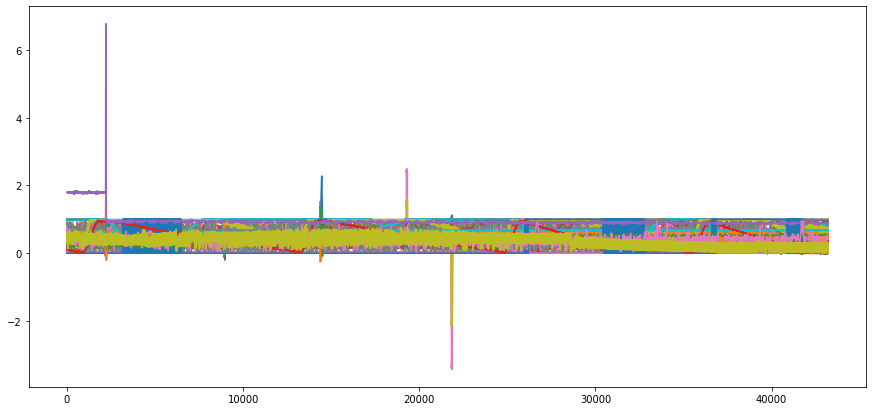

In [29]:
plt.figure(figsize=(15, 7))
plt.plot(VALIDATION_DF)
# VALIDATION_DF.plot()

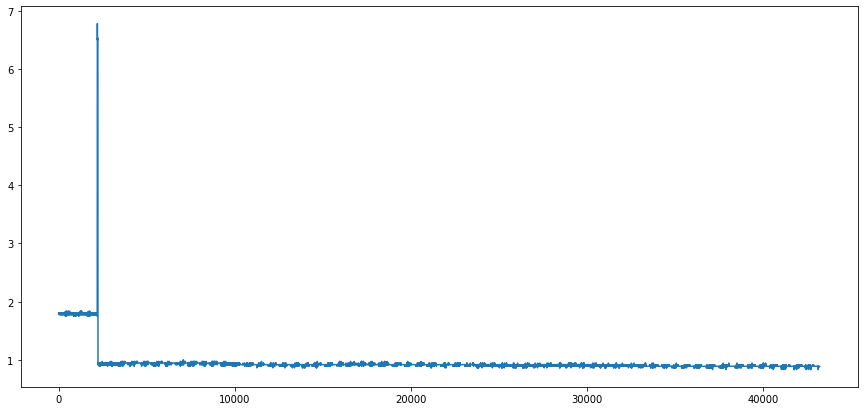

In [30]:
plt.figure(figsize=(15, 7))
plt.plot(VALIDATION_DF['C75'])

In [31]:
# valid 그래프를 보고 앞부분 정상인데 값이 튀는 변수가 있어서 조절
VALIDATION_DF['C75'][:2110] = 0.95

In [32]:
val = np.array(VALIDATION_DF)
x_val = val.reshape(val.shape[0], 1, val.shape[1])
x_val.shape

(43201, 1, 79)

In [33]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

In [34]:
start = time.time()
valid_x_predictions = model.predict(x_val)
print(valid_x_predictions.shape)

error = flatten(x_val) - flatten(valid_x_predictions)
print((flatten(x_val) - flatten(valid_x_predictions)).shape)

valid_mse = np.mean(np.power(flatten(x_val) - flatten(valid_x_predictions), 2), axis=1)
print(valid_mse.shape)
print(time.time()-start)

(43201, 1, 79)
(43201, 79)
(43201,)
2.496335029602051


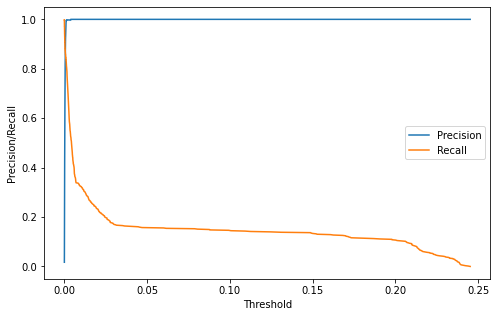

In [35]:
error_df = pd.DataFrame({'Reconstruction_error': valid_mse, 
                         'True_class':list(VALIDATION_DF_RAW['attack'])})
precision_rt, recall_rt, threshold_rt = metrics.precision_recall_curve(error_df['True_class'], error_df['Reconstruction_error'])

plt.figure(figsize=(8,5))
plt.plot(threshold_rt, precision_rt[1:], label='Precision')
plt.plot(threshold_rt, recall_rt[1:], label='Recall')
plt.xlabel('Threshold'); plt.ylabel('Precision/Recall')
plt.legend()
plt.show()
##recall과 precision이 교차하는 지점이 threshold

In [36]:
index_cnt = [cnt for cnt, (p, r) in enumerate(zip(precision_rt, recall_rt)) if p==r][0]
print('precision: ',precision_rt[index_cnt],', recall: ',recall_rt[index_cnt])

# fixed Threshold
threshold_fixed = threshold_rt[index_cnt]
print('threshold: ',threshold_fixed)

precision:  0.8648648648648649 , recall:  0.8648648648648649
threshold:  0.0006140553118746306


Text(0.5, 0, 'Data point index')

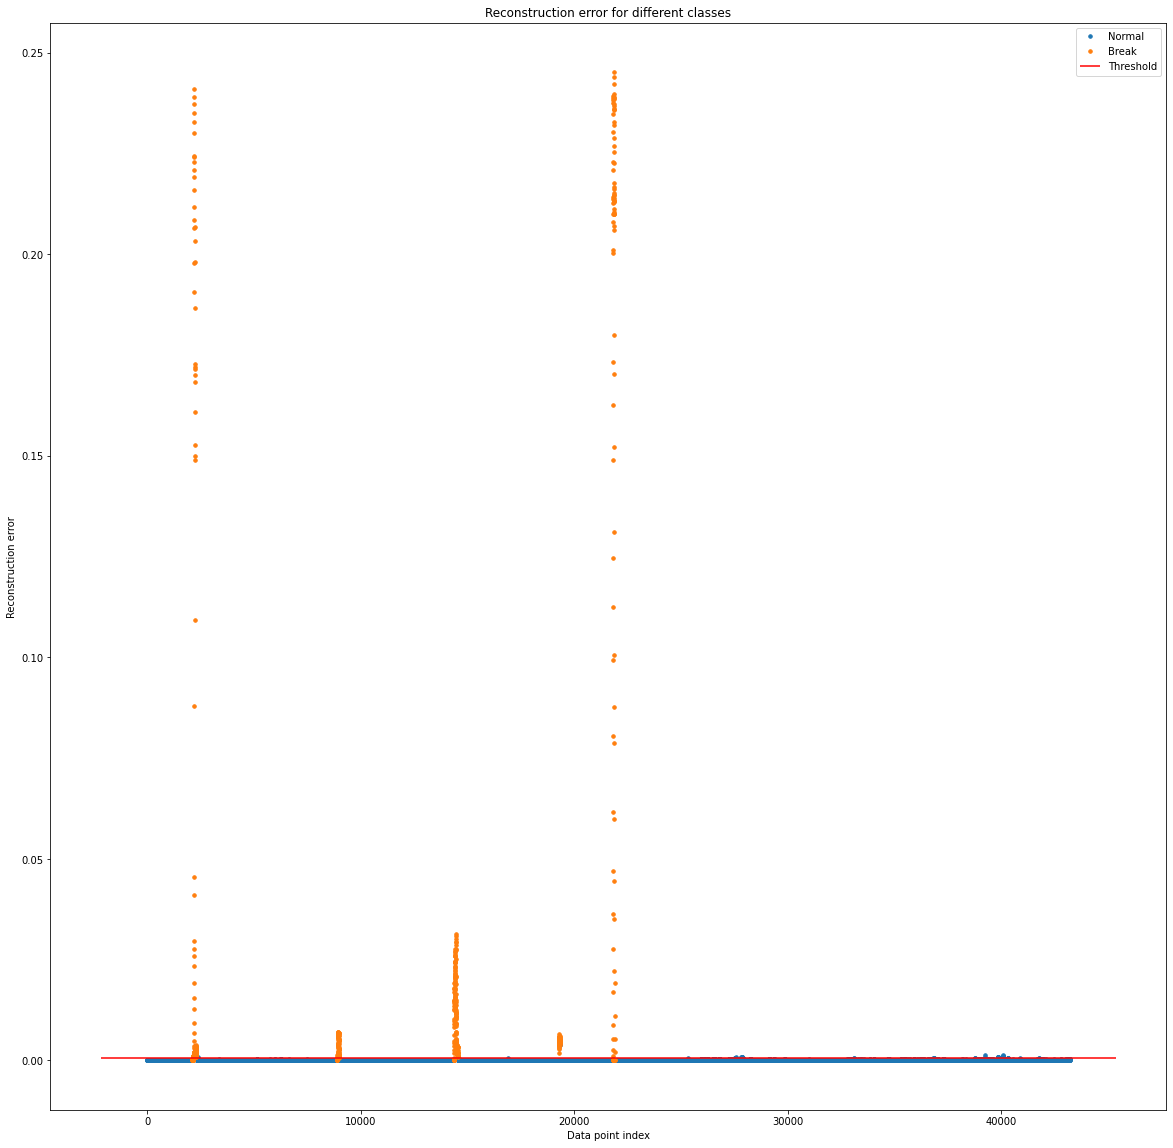

In [37]:
error_df = pd.DataFrame({'Reconstruction_error': valid_mse ,
                         'True_class': list(VALIDATION_DF_RAW['attack'])})
groups = error_df.groupby('True_class')
fig, ax = plt.subplots(figsize=(20,20))

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
    
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()

plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")

In [38]:
threshold_fixed = 0.0015

Text(0.5, 0, 'Data point index')

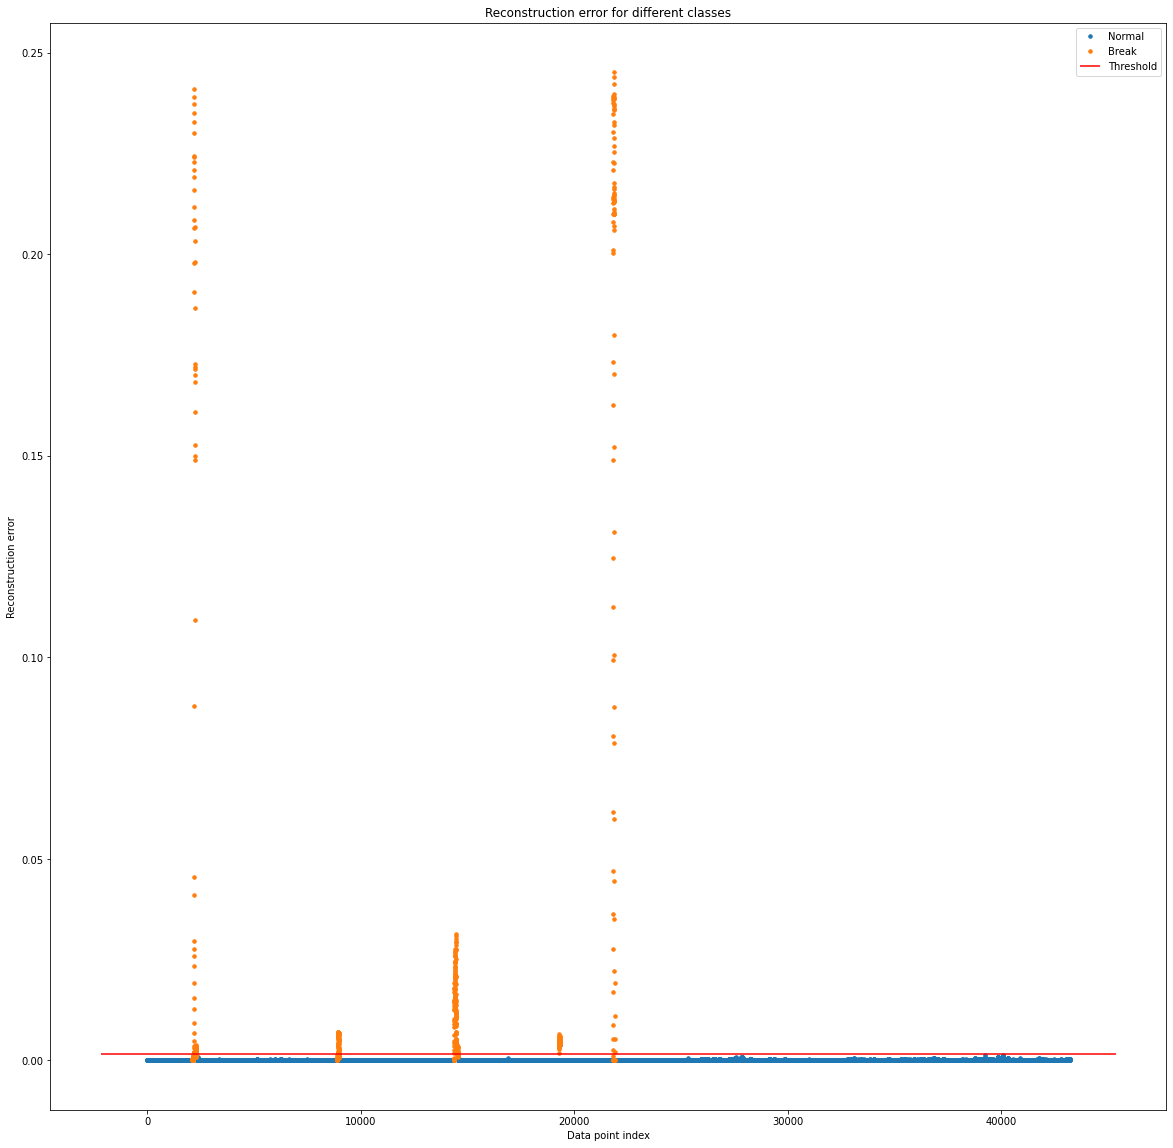

In [39]:
error_df = pd.DataFrame({'Reconstruction_error': valid_mse ,
                         'True_class': list(VALIDATION_DF_RAW['attack'])})
groups = error_df.groupby('True_class')
fig, ax = plt.subplots(figsize=(20,20))

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
    
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()

plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")

In [40]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df['Reconstruction_error'].values]
pred_y = np.array(pred_y)
pred_y.shape

(43201,)

In [41]:
ATTACK_LABELS = np.array(VALIDATION_DF_RAW[ATTACK_FIELD])
FINAL_LABELS = np.array(pred_y)

ATTACK_LABELS.shape[0] == FINAL_LABELS.shape[0]

True

In [42]:
TaPR = etapr.evaluate(anomalies=ATTACK_LABELS, predictions=FINAL_LABELS)
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

F1: 0.955 (TaP: 1.000, TaR: 0.914)
# of detected anomalies: 5
Detected anomalies: ['1', '2', '3', '4', '5']


In [43]:
TEST_DF_RAW = dataframe_from_csvs(TEST_DATASET)
TEST_DF_RAW

,time,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
0,2020-07-09 15:00:00,384.30737,12.0,10,70.35980,-1.6171,-1.79901,774.20752,28.02385,136,-4.0334,-0.00231,284.39673,85.74829,10,1119.12622,382.21698,-29.0,0,1,15844.0,0,1,0.09042,18991.0,763.19324,315.48346,14.52789,0,1.25036,35.48279,1985.39734,10051.0,10,1,1,99.98731,10,1118.61084,35.37903,0,92.51556,-26.0,20,3.9907,220.14613,11.86442,54065.0,0,774.0,-224,1,0,-0.00015,92.69160,69.76647,2835.65454,0.27557,-0.00723,70,2835.65454,540833,697.39990,540833,1,2880,83.46329,0,0.09874,27600.0,936.58447,0.0,1.35437,13.97231,35.22338,12.02545,293.51129,283.92651,32.0,6.5059
1,2020-07-09 15:00:01,384.30737,12.0,10,70.35980,-1.7606,-1.79901,772.58758,28.02730,136,-4.0404,-0.00181,283.47436,85.74829,10,1117.85059,382.21698,-28.0,0,1,15808.0,0,1,0.09042,18991.0,763.19324,315.10199,14.52789,0,1.24944,35.48279,1972.99939,10052.0,10,1,1,100.00000,10,1118.61084,35.37674,0,92.51556,-27.0,20,3.5714,218.23881,11.92675,54073.0,0,773.0,-224,1,0,-0.00015,92.64934,69.74272,2832.98731,0.27634,-0.00723,70,2832.98731,540833,704.41895,540833,1,2880,83.40041,0,0.09874,27600.0,940.93317,0.0,1.35437,13.93358,35.20813,12.02545,292.67938,283.36591,32.0,6.3079
2,2020-07-09 15:00:02,384.20517,12.0,10,70.35980,-1.7606,-1.80664,772.58758,28.02730,136,-4.0404,0.00007,282.69678,85.74829,10,1118.48840,382.21698,-23.0,0,1,15734.0,0,1,0.09042,18991.0,763.19324,316.05570,14.52026,0,1.24746,35.48279,1981.58276,10052.0,10,1,1,99.98115,10,1118.61084,35.37178,0,92.51556,-27.0,20,3.5714,216.90367,11.92675,54073.0,0,773.0,-224,1,0,0.00007,92.91075,69.77000,2842.25244,0.27634,-0.00723,70,2842.25244,540833,704.41895,540833,1,2880,83.34054,0,0.09874,27595.0,936.58447,0.0,1.35513,13.95248,35.20813,12.02545,291.90179,282.93189,32.0,6.3079
3,2020-07-09 15:00:03,384.25626,12.0,10,70.35980,-1.7814,-1.79901,777.48810,28.02905,136,-3.8861,0.00000,283.04034,85.74829,10,1117.85059,382.21698,-29.0,0,1,15710.0,0,1,0.09042,18991.0,763.19324,315.10199,14.51263,0,1.24624,35.48279,1979.86585,10053.0,10,1,1,100.00000,10,1118.61084,35.36873,0,92.51556,-27.0,20,3.3456,221.67204,11.96341,54086.0,0,777.0,-224,1,0,-0.00015,92.92407,69.70607,2833.12744,0.27557,-0.00723,70,2833.12744,540833,704.35791,540833,1,2880,83.26884,0,0.09874,27590.0,933.54034,0.0,1.35513,13.89971,35.20813,12.02545,291.59430,282.06378,32.0,6.1203
4,2020-07-09 15:00:04,384.20517,12.0,10,70.35980,-1.7370,-1.79901,778.42212,28.03169,136,-3.6790,-0.00029,281.99145,85.63384,10,1119.44507,382.21698,-29.0,0,1,15608.0,0,1,0.09042,18992.0,763.19324,315.48346,14.52026,0,1.24364,35.48279,1977.19556,10052.0,10,1,1,100.00000,10,1118.61084,35.36224,0,92.51556,-26.0,20,3.2272,218.23881,11.99236,54086.0,0,778.0,-224,1,0,0.00007,93.05405,69.76971,2839.44482,0.27710,-0.00723,70,2839.44482,540833,700.89111,540833,1,2880,83.18826,0,0.09874,27588.0,944.41223,0.0,1.35437,13.94603,35.20813,12.02545,289.87628,283.67334,32.0,5.9543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92396,2020-07-31 12:29:56,420.08923,12.0,10,48.31848,-0.8706,97.19238,786.54382,28.03253,232,-3.4769,-0.00231,431.51404,40.38391,10,983.98590,417.58124,-22.0,0,1,19259.0,0,1,71.14441,7140.0,763.19324,240.17335,8.83636,0,1.45290,37.89367,6.14166,10052.0,10,1,1,0.00000,10,989.50207,35.97946,0,3.39661,-20.0,20,3.9836,168.64778,11.87761,54088.0,0,787.0,15248,1,0,-0.00022,3.67038,47.56297,32.97053,0.20462,71.67969,70,31.97761,540833,705.32837,540833,1,2880,40.20410,0,0.06112,27627.0,824.82147,10

In [44]:
TEST_DF = normalize(TEST_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TEST_DF

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
0,0.273715,0.0,0.0,0.828325,0.225882,0.000999,0.318761,0.333825,0.010417,0.139867,0.487693,0.198263,0.808607,0.0,0.899123,0.159596,-0.000366,0.0,0.0,0.225073,0.0,0.0,0.000418,0.949670,0.0,0.880684,0.504186,0.0,0.274269,0.092179,0.989424,0.329327,0.0,0.0,0.0,0.999873,0.0,0.985637,0.264512,0.0,0.924960,-0.000513,0.0,0.574677,0.482436,0.343670,0.431818,0.0,0.316456,0.003422,0.0,0.0,0.581043,0.926916,0.844788,0.992272,0.048368,0.000000,0.0,0.992272,0.0,0.359459,0.0,0.0,0.0,0.779812,0.0,0.955389,0.707071,0.677723,0.0,0.317842,0.452044,0.236483,0.944440,0.225971,0.200389,0.26162,0.714722
1,0.273715,0.0,0.0,0.828325,0.171634,0.000999,0.300187,0.426398,0.010417,0.137445,0.492115,0.195142,0.808607,0.0,0.895009,0.159596,-0.000199,0.0,0.0,0.222785,0.0,0.0,0.000418,0.949670,0.0,0.878304,0.504186,0.0,0.273512,0.092179,0.983793,0.331512,0.0,0.0,0.0,0.999988,0.0,0.985637,0.264044,0.0,0.924960,-0.000747,0.0,0.435549,0.478887,0.531007,0.459366,0.0,0.304948,0.003422,0.0,0.0,0.581043,0.926532,0.844029,0.991415,0.048689,0.000000,0.0,0.991415,0.0,0.412018,0.0,0.0,0.0,0.779051,0.0,0.955389,0.707071,0.680584,0.0,0.317842,0.450701,0.230344,0.944440,0.223121,0.198499,0.26162,0.650106
2,0.272825,0.0,0.0,0.828325,0.166747,0.000930,0.298514,0.434738,0.010417,0.137227,0.508991,0.192253,0.808607,0.0,0.896677,0.159596,0.000639,0.0,0.0,0.217918,0.0,0.0,0.000418,0.949670,0.0,0.883986,0.503942,0.0,0.271830,0.092179,0.987149,0.331709,0.0,0.0,0.0,0.999829,0.0,0.985637,0.262997,0.0,0.924960,-0.000768,0.0,0.423015,0.476106,0.547884,0.461848,0.0,0.303912,0.003422,0.0,0.0,0.583371,0.928852,0.844824,0.994285,0.048718,0.000000,0.0,0.994285,0.0,0.416753,0.0,0.0,0.0,0.778264,0.0,0.955389,0.661571,0.678007,0.0,0.318290,0.451229,0.229791,0.944440,0.220223,0.196880,0.26162,0.644285
3,0.273182,0.0,0.0,0.828325,0.158478,0.000992,0.353980,0.482056,0.010417,0.190063,0.510049,0.193118,0.808607,0.0,0.894805,0.159596,-0.000265,0.0,0.0,0.215925,0.0,0.0,0.000418,0.949670,0.0,0.878657,0.503675,0.0,0.270669,0.092179,0.986709,0.333892,0.0,0.0,0.0,0.999983,0.0,0.985637,0.262277,0.0,0.924960,-0.000770,0.0,0.347594,0.484614,0.658648,0.506417,0.0,0.349383,0.003422,0.0,0.0,0.581276,0.929202,0.842882,0.991670,0.048403,0.000000,0.0,0.991670,0.0,0.416770,0.0,0.0,0.0,0.777327,0.0,0.955389,0.611607,0.675769,0.0,0.318335,0.449470,0.229736,0.944440,0.218893,0.193823,0.26162,0.583093
4,0.272773,0.0,0.0,0.828325,0.174269,0.000998,0.370123,0.556914,0.010417,0.266280,0.507615,0.189690,0.807223,0.0,0.899709,0.159596,-0.000356,0.0,0.0,0.209307,0.0,0.0,0.000418,0.949731,0.0,0.880481,0.503892,0.0,0.268436,0.092179,0.985464,0.331947,0.0,0.0,0.0,0.999998,0.0,0.985637,0.260891,0.0,0.924960,-0.000539,0.0,0.301165,0.479140,0.755855,0.510869,0.0,0.365318,0.003422,0.0,0.0,0.583392,0.930407,0.844699,0.993416,0.049004,0.000000,0.0,0.993416,0.0,0.391071,0.0,0.0,0.0,0.776268,0.0,0.955389,0.588433,0.682626,0.0,0.317891,0.450884,0.229731,0.944440,0.212932,0.198888,0.26162,0.523348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92396,0.619520,0.0,0.0,0.073426,0.532147,0.998079,0.476720,0.581066,0.017489,0.358745,0.489188,0.745671,0.199386,0.0,0.419343,0.612529,0.000896,0.0,0.0,0.463641,0.0,0.0,0.820238,0.142629,0.0,0.362851,0.302727,0.0,0.457515,0.533266,0.000685,0.331426,0.0,0.0,0.0,0.000000,0.0,0.428804,0.399453,0.0,0.031439,0.001027,0.0,0.553210,0.377111,0.414363,0.532206,0.0,0.482937,0.830538,0.0,0.0,0.580477,0.036732,0.065087,0.002776

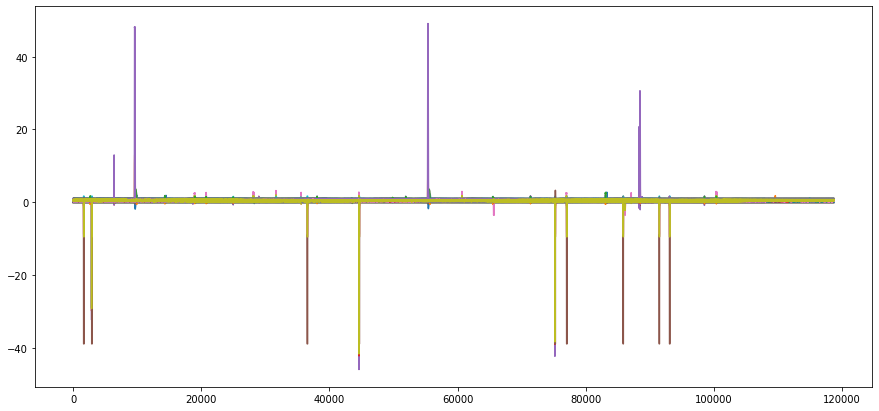

In [45]:
plt.figure(figsize=(15, 7))
plt.plot(TEST_DF)

In [46]:
boundary_check(TEST_DF)

(True, True, False)

In [47]:
test = np.array(TEST_DF)
x_test = test.reshape(test.shape[0], 1, test.shape[1])
x_test.shape

(358804, 1, 79)

In [48]:
start = time.time()
test_x_predictions = model.predict(x_test)
#print(test_x_predictions)
print(test_x_predictions.shape)
#print((flatten(x_test) - flatten(test_x_predictions)).shape)
test_mse = np.mean(np.power(flatten(x_test) - flatten(test_x_predictions), 2), axis=1)
print(test_mse.shape)
print(time.time()-start)

(358804, 1, 79)
(358804,)
16.40132999420166


In [49]:
test_error = pd.DataFrame({'Reconstruction_error': test_mse})

In [50]:
test_threshold = 0.0015

In [51]:
pred_y_test = [1 if e > test_threshold else 0 for e in test_error['Reconstruction_error'].values]
pred_y_test = np.array(pred_y_test)
pred_y_test.shape

(358804,)

In [52]:
submission = pd.read_csv('./HAI 2.0/sample_submission.csv')
submission.index = submission['time']
submission['attack'] = pred_y_test

In [53]:
submission['attack'].value_counts()

0    353127
1      5677
Name: attack, dtype: int64

Text(0.5, 0, 'Data point index')

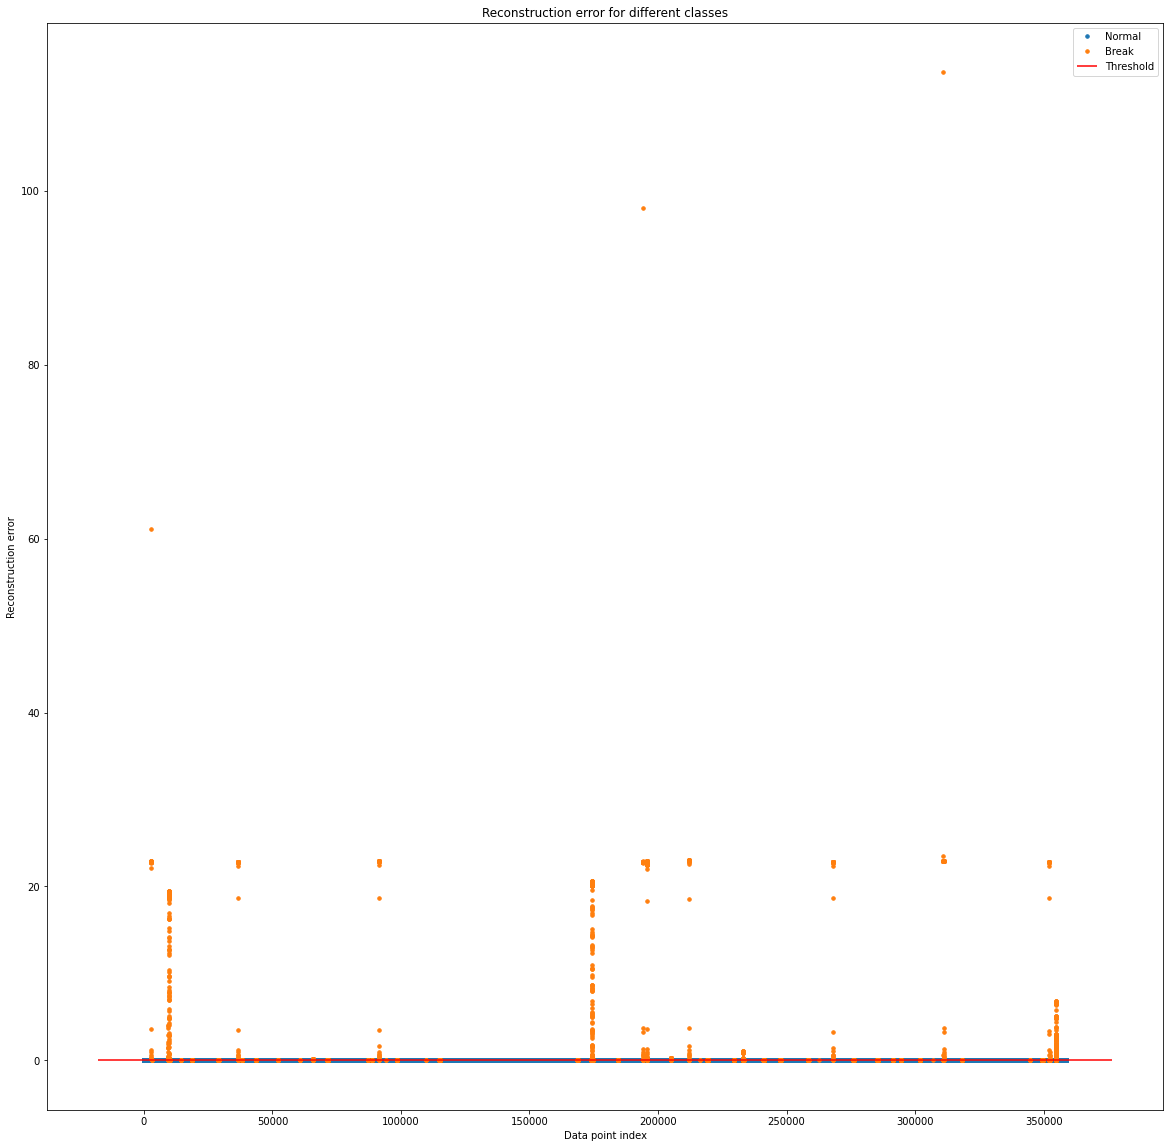

In [54]:
test_error_df = pd.DataFrame({'Reconstruction_error': test_mse,
                         'True_class': list(submission['attack'])})
groups = test_error_df.groupby('True_class')
fig, ax = plt.subplots(figsize=(20,20))

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
    
ax.hlines(test_threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()

plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")